# Исследование животных зоопрака

## Установка зависимостей

В следующей ячейке способ установки окружения прямо из ноутбука. <br/>
Так можем убедиться в наличии нужных библиотек в случае запуска на другом ПК, где зависимости еще не установлены.

In [60]:
%pip install pandas matplotlib seaborn openpyxl faker pendulum

Note: you may need to restart the kernel to use updated packages.


## Импорт библиотек

In [61]:
# standard libraries
from pathlib import Path
from functools import partial
import random
# third party libs
import pendulum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from faker import Faker
import matplotlib_inline
# my custom libs if exists
# ...

## Настройка окружения

In [62]:
sns.set_style("darkgrid")
fake = Faker()

## Обзор данных

In [63]:
# animals_path = Path("~/datasets/students/Animals.xlsx")
species_data_path = Path("~/datasets/students/specie_data.xlsx")

In [64]:
species = pd.read_excel(species_data_path)
species.sample(10) # Выбрать 10 случайных строк

,Species,Adult height,Child's height,Adult weight,Child's weight,Lifespan
73,Equus zebra,200.0,80.0,400.00,20.000,30
61,White-breasted hedgehog,29.0,5.8,0.90,0.090,4
40,Pink Flamingo,145.0,29.0,3.50,0.350,50
0,Chinese Alligator,220.0,44.0,45.00,4.500,50
31,Shiloklyovka,48.0,9.6,0.32,0.032,15
46,Fennec,40.0,8.0,1.50,0.150,20
22,Lowland Gorilla,165.0,33.0,130.00,13.000,50
13,Bristly Armadillo,38.0,7.6,0.90,0.090,16
72,Macropodidae,200.0,40.0,50.00,3.000,50
50,Fire-backed Pheasant,70.0,14.0,1.20,0.120,12


In [65]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         75 non-null     object 
 1   Adult height    75 non-null     float64
 2   Child's height  75 non-null     float64
 3   Adult weight    75 non-null     float64
 4   Child's weight  75 non-null     float64
 5   Lifespan        75 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ KB


In [66]:
species.describe(include="object")

,Species
count,75
unique,75
top,Chinese Alligator
freq,1


In [67]:
species.describe(include="number")

,Adult height,Child's height,Adult weight,Child's weight,Lifespan
count,75.00000,75.000000,75.000000,75.000000,75.000000
mean,115.70000,27.646667,112.260733,7.739407,28.720000
std,85.45858,30.840366,536.377493,26.439330,17.620289
min,23.00000,4.600000,0.125000,0.012500,3.000000
25%,60.00000,11.600000,1.000000,0.100000,15.000000
50%,90.00000,18.000000,3.500000,0.350000,25.000000
75%,145.00000,29.000000,40.000000,3.500000,40.000000
max,500.00000,200.000000,4500.000000,200.000000,80.000000


__Вывод__:
1. ...
2. ...

Здесь комментарии относительно скошенности, средних значений, диапозона значений, наличия/отсутствия пропусков.

## Генерация

In [68]:
def generate_date(
    duration: int,
    end_date: str,
) -> pendulum.DateTime:
    """Генерирует случайную дату от `end_date` на отрезке `duration` в сторону прошлого.

    Parameters
    ----------
    duration : int
        Отрезок в прошлое длиной в годы
    end_date : str
        Дата обратного отсчёта

    Returns
    -------
    DateTime
        Случайная дата
    """
    end_date = pendulum.parse(end_date)
    start_date = end_date.add(years=-duration)
    birthday_date = fake.date_time_between(start_date=start_date, end_date=end_date)
    # TODO: проверка даты
    return birthday_date

In [69]:
# Генерация даты рождения
end_date = pendulum.today("UTC").to_datetime_string()
print("Today is:", end_date)
# Используем силу pandas для создания новой колонки данных
# функция map для серий преобразует каждый элемент серии
# partial - средство стандартной библиотеки functools, фиксирует часть аргументов функции константными значениями
# в случае ниже зафиксировали аргумент end_date функции generate_date
bithday = species["Lifespan"].map(partial(generate_date, end_date=end_date)) 
animals = pd.DataFrame({"bithday": bithday})
del bithday # принудительно удаляем промежуточный объект из памяти за ненадобностью. 
animals.head()

Today is: 2024-03-06 00:00:00


,bithday
0,2008-01-07 09:13:30.703957
1,1972-12-10 01:24:59.864737
2,2021-01-18 05:56:27.482626
3,1979-04-14 17:05:24.455406
4,2006-10-30 08:31:07.879318


In [89]:
# Создаем новую колонку в таблице animals c весами
# Что такое lambda функции: https://habr.com/ru/companies/piter/articles/674234/
animals["weight"] = species[["Adult weight", "Child's weight"]].apply(lambda s: random.uniform(*s), axis=1).round(2)
animals["height"] = species[["Adult height", "Child's height"]].apply(lambda s: random.uniform(*s), axis=1).round(2)
animals["age"] = pendulum.today("UTC").year - animals["bithday"].dt.year
animals["life_span"] = species["Lifespan"]
animals["spent_life"] = (animals["age"]*100) // species["Lifespan"]
# Так можно разбить на группы по квантилям (quantile) — наиболее общий термин,
# который обозначает, значение совпадающее или ниже, чем определенная доля значений данных.
# https://ru.wikipedia.org/wiki/Квантиль
animals["age_group"] = pd.qcut(animals["spent_life"], 3, labels=["child", "adult", "old"])
animals.head()

,bithday,weight,height,age,spent_life,age_group,life_span
0,2008-01-07 09:13:30.703957,30.93,173.01,16,32,adult,50
1,1972-12-10 01:24:59.864737,0.14,23.03,52,86,old,60
2,2021-01-18 05:56:27.482626,0.14,11.26,3,6,child,50
3,1979-04-14 17:05:24.455406,0.37,28.05,45,64,old,70
4,2006-10-30 08:31:07.879318,25.07,56.59,18,90,old,20


## Анализ

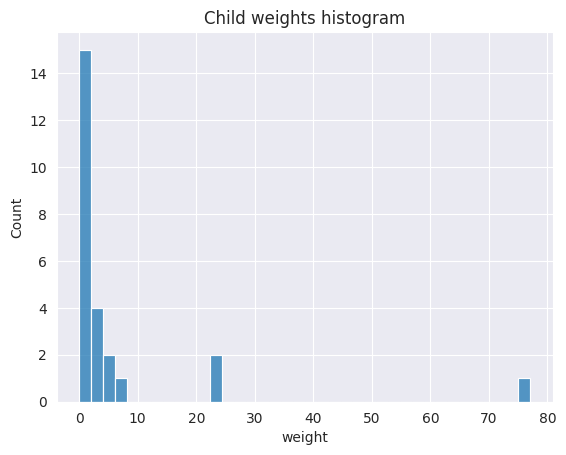

In [88]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html#pandas.DataFrame.query
ax = sns.histplot(
    data=animals.query("`age_group` == 'child'").sort_values(by="weight"), 
    x="weight",
)
_ = ax.set_title("Child weights histogram")

__Вывод__:
1. ...
2. ...

Здесь комментарии относительно скошенности, средних значений, диапозона значений, наличия/отсутствия пропусков.